In [295]:
import torch
t_version = str(torch.__version__)
s_src = f"https://pytorch-geometric.com/whl/torch-{t_version}.html"
sp_src = f"https://pytorch-geometric.com/whl/torch-{t_version}.html"
!pip install torch-scatter -f $s_src
!pip install torch-sparse -f $sp_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
  Preparing metadata (setup.py) ... done


In [296]:
import torch_geometric
torch_geometric.__version__

'2.6.1'

In [331]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch_scatter
import torch_geometric.nn as pyg_nn
import copy
import time
import networkx as nx
import requests
from torch_scatter import scatter
from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from tqdm import trange
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

# Define Graph Neural Network Stack
class GraphNNStack(nn.Module):
    def __init__(self, input_features, hidden_features, output_classes, configuration, use_embeddings=False):
        super(GraphNNStack, self).__init__()
        conv_layer_class = self.select_conv_layer(configuration.model_type)
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(conv_layer_class(input_features, hidden_features))

        assert configuration.num_layers >= 1, 'Number of layers must be >= 1'
        for _ in range(configuration.num_layers - 1):
            self.conv_layers.append(conv_layer_class(configuration.heads * hidden_features, hidden_features))

        self.post_mp_layers = nn.Sequential(
            nn.Linear(configuration.heads * hidden_features, hidden_features),
            nn.Dropout(configuration.dropout),
            nn.Linear(hidden_features, output_classes)
        )
        self.dropout_rate = configuration.dropout
        self.num_layers = configuration.num_layers
        self.use_embeddings = use_embeddings

    def select_conv_layer(self, conv_type):
        if conv_type == 'MGCN':
            return MGCN
        else:
            raise ValueError(f"Unknown model type: {conv_type}")

    def forward_pass(self, graph_data):
        features, edge_indices, batches = graph_data.x, graph_data.edge_index, graph_data.batch
        for conv_layer in self.conv_layers:
            features = conv_layer(features, edge_indices)
            features = F.relu(features)
            features = F.dropout(features, p=self.dropout_rate, training=self.training)
        features = self.post_mp_layers(features)
        if self.use_embeddings:
            return features
        return F.log_softmax(features, dim=1)

    def calculate_loss(self, predictions, labels):
        return F.nll_loss(predictions, labels)

In [332]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree, softmax
from torch.nn import Parameter

class MGCN(MessagePassing):
    def __init__(self,in_channels, out_channels,dropout=0.5,
                 negative_slope=0.2,residual=True,heads=1, attention=False):
        super(MGCN, self).__init__(aggr='add')
        self.negative_slope = negative_slope

        if attention and out_channels % heads != 0:
            raise ValueError(f"out_channels ({out_channels}) must be divisible by heads ({heads})")

        self.lin = nn.Linear(in_channels, out_channels, bias=True)
        self.dropout = dropout
        self.residual = residual
        self.attention = attention

        if residual:
            self.res_lin = nn.Linear(in_channels, out_channels) if in_channels != out_channels else nn.Identity()

        if attention:
            self.heads = heads
            self.out_channels = out_channels // heads
            self.att_lin = nn.Linear(2 * self.out_channels, 1)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        if hasattr(self, 'res_lin') and not isinstance(self.res_lin, nn.Identity):
            self.res_lin.reset_parameters()
        if hasattr(self, 'att_lin'):
            self.att_lin.reset_parameters()
    def forward(self, x, edge_index,edge_weight=None):
        res = x if self.residual else None

        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index

        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = (deg + 1e-5).pow(-0.5).clamp(max=1e4)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)

        if edge_weight is not None:
            num_self_loops = x.size(0)
            edge_weight = torch.cat([edge_weight, torch.ones(num_self_loops, device=edge_index.device)])
            norm = norm * edge_weight

        if self.attention:
            x = x.view(-1, self.heads, self.out_channels)
            out = self.propagate(edge_index, x=x, norm=norm)

            out = out.view(-1, self.heads * self.out_channels)

            if self.residual:
              out = F.relu(out) + self.res_lin(res)
            else:
              out = F.relu(out)
            return out
        else:
            out = self.propagate(edge_index, x=x, norm=norm)
            if self.residual:
                out = out + self.res_lin(res)
            return F.relu(out)

    def message(self, x_j, x_i, norm, index):
        if self.attention:
            x_j = x_j.view(-1, self.heads, self.out_channels)
            x_i = x_i.view(-1, self.heads, self.out_channels)
            alpha = torch.cat([x_i, x_j], dim=-1)
            alpha = F.leaky_relu(self.att_lin(alpha).squeeze(-1),negative_slope=self.negative_slope)
            alpha = softmax(alpha / np.sqrt(self.out_channels), index)  # Scale by sqrt(d_k)
            return (alpha.unsqueeze(-1) * x_j).view(-1, self.heads * self.out_channels)
        else:
            return norm.view(-1, 1) * x_j

In [334]:
import torch.optim as optim
def setup_optimizer_and_scheduler(configuration, model_params):
    weight_decay = configuration.weight_decay
    trainable_params = filter(lambda p: p.requires_grad, model_params)

    if configuration.optimizer == 'adam':
        optimizer = optim.Adam(trainable_params, lr=configuration.learning_rate, weight_decay=weight_decay)
    elif configuration.optimizer == 'sgd':
        optimizer = optim.SGD(trainable_params, lr=configuration.learning_rate, momentum=0.95, weight_decay=weight_decay)
    elif configuration.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(trainable_params, lr=configuration.learning_rate, weight_decay=weight_decay)
    elif configuration.optimizer == 'adagrad':
        optimizer = optim.Adagrad(trainable_params, lr=configuration.learning_rate, weight_decay=weight_decay)

    if configuration.scheduler == 'none':
        return None, optimizer
    elif configuration.scheduler == 'step':
        scheduler = StepLR(optimizer, step_size=configuration.decay_step, gamma=configuration.decay_rate)
    elif configuration.scheduler == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=configuration.restart_interval)
    return scheduler, optimizer

In [335]:
import time
import numpy as np
import torch
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_metrics(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Train the Model
def train_model(graph_dataset, configuration):
    print("Node task. Train set size:", np.sum(graph_dataset[0]['train_mask'].numpy()))
    train_loader = DataLoader(graph_dataset, batch_size=configuration.batch_size, shuffle=True)
    test_loader = DataLoader(graph_dataset, batch_size=configuration.batch_size, shuffle=False)

    model = GraphNNStack(graph_dataset.num_node_features, configuration.hidden_dim, graph_dataset.num_classes, configuration)
    scheduler, optimizer = setup_optimizer_and_scheduler(configuration, model.parameters())

    losses = []
    test_accuracies = []
    for epoch in range(configuration.epochs):
        total_loss = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            predictions = model.forward_pass(batch)
            labels = batch.y
            predictions = predictions[batch.train_mask]
            labels = labels[batch.train_mask]
            loss = model.calculate_loss(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            test_accuracy, _, _, _, _ = evaluate_model(test_loader, model)
            test_accuracies.append(test_accuracy)
        else:
            test_accuracies.append(test_accuracies[-1])

    return test_accuracies, losses, model

# Evaluate the Model
def evaluate_model(loader, model, validation=False):
    model.eval()
    correct_predictions = 0
    all_predictions = []
    all_labels = []

    for graph_data in loader:
        with torch.no_grad():
            predictions = model.forward_pass(graph_data).max(dim=1)[1]
            labels = graph_data.y
        mask = graph_data.val_mask if validation else graph_data.test_mask
        predictions = predictions[mask]
        labels = labels[mask]
        all_predictions.append(predictions)
        all_labels.append(labels)
        correct_predictions += predictions.eq(labels).sum().item()

    total_samples = 0
    for graph_data in loader.dataset:
        total_samples += torch.sum(graph_data.val_mask if validation else graph_data.test_mask).item()

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    accuracy, precision, recall, f1 = evaluate_metrics(all_predictions, all_labels)

    return correct_predictions / total_samples, accuracy, precision, recall, f1

class Config:
    def __init__(self, parameters):
        self.__dict__.update(parameters)

Training model: MGCN
Node task. Train set size: 60
Calculating metrics for the best model...
Model: MGCN
Dataset: pubmed
Max Accuracy: 0.7900
Min Loss: 0.0230
Hit Ratio: 0.7740
Precision: 0.7776
Recall: 0.7740
F1 Score: 0.7739
Time Taken: 152.58 seconds
--------------------------------------


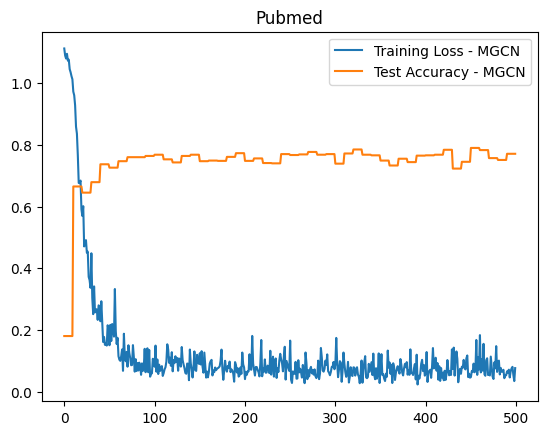

In [338]:
def main():
    configurations = [
        {
            'model_type': 'MGCN',
            'dataset': 'pubmed',
            'num_layers': 2,
            'heads': 1,
            'batch_size': 32,
            'hidden_dim': 32,
            'dropout': 0.5,
            'epochs': 500,
            'optimizer': 'adam',
            'scheduler': 'none',
            'restart_interval': 0,
            'weight_decay': 5e-3,
            'learning_rate': 0.01
        },
    ]

    for config_dict in configurations:
        config = Config(config_dict)
        for model_name in ['MGCN']:
            config.model_type = model_name
            print(f"Training model: {model_name}")

            if model_name == 'GAT':
                config.heads = 2
            else:
                config.heads = 1

            if config.dataset == 'pubmed':
                graph_dataset = Planetoid(root='/tmp/pubmed', name='Pubmed')
            else:
                raise NotImplementedError("Unknown dataset")

            start_time = time.time()
            test_accuracies, losses, best_model = train_model(graph_dataset, config)
            end_time = time.time()
            elapsed_time = end_time - start_time

            print("Calculating metrics for the best model...")
            test_loader = DataLoader(graph_dataset, batch_size=config.batch_size, shuffle=False)
            hit_ratio, accuracy, precision, recall, f1 = evaluate_model(test_loader, best_model, validation=False)

            print(f"Model: {model_name}")
            print(f"Dataset: {config.dataset}")
            print(f"Max Accuracy: {max(test_accuracies):.4f}")
            print(f"Min Loss: {min(losses):.4f}")
            print(f"Hit Ratio: {hit_ratio:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Time Taken: {elapsed_time:.2f} seconds")
            print("--------------------------------------")

            plt.title(graph_dataset.name)
            plt.plot(losses, label=f"Training Loss - {config.model_type}")
            plt.plot(test_accuracies, label=f"Test Accuracy - {config.model_type}")
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()